# *Manufacturing Root Cause: Modeling!*

****************************************************************************************************************************************

In [2]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


# 3. Modeling  

In [3]:
url_final = 'https://dl.dropboxusercontent.com/scl/fi/ep8vuirz46gkhw4a3yfw6/final_dataset.csv?rlkey=b9ji5utoaahhkmsoebup6q95q&dl=1'
df_final = pd.read_csv(url_final)

In [36]:
df_final.shape

(284700, 25)

Download 'df_final' as csv file

In [51]:
df_final.to_csv('final_dataset.csv', index=False)

In [37]:
df_final.head()

,COIL,MT_ADJUSTED,DATE,TIME_START_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,SPEED_PROCESS,FILL_TIRO,LASER_FRN_1,ELET_FE2,...,LASER_FRN_9,DEC_FE2,DEC_FE3,LASER_FRN_8,SPZ1_R1_ASS,FRN_FURNACE_PRESSURE,AIR_CH4_1,FILL_FORZA,PRES_ZONA3_MEASURED,Has_Defect
580,297712,0.0,2019-03-03,16:00:17.140,-0.626250,0.589075,-1.749652,-0.003943,1.130454,-0.024409,...,-0.921559,-0.019089,0.006705,-3.281993,-0.005561,3.480863,5.618876,-0.006274,-0.362265,0.0
581,297712,7.0,2019-03-03,16:01:02.140,-0.548642,0.310833,-1.423870,-0.003943,1.167358,-0.024409,...,-0.882066,-0.019089,0.006705,-3.286931,-0.005561,4.155847,5.606975,-0.006274,-3.121354,0.0
582,297712,14.0,2019-03-03,16:01:32.140,-0.489710,0.219359,-1.249998,-0.003943,1.169191,-0.024409,...,-0.895256,-0.019089,0.006705,-3.283506,-0.005561,3.724010,5.505825,-0.006274,-2.903597,0.0
583,297712,21.0,2019-03-03,16:01:47.080,-0.472777,0.560960,-1.250524,-2.503042,1.183099,-0.024409,...,-0.888345,-0.019089,0.006705,-3.239610,-0.005561,3.202527,5.599273,-1.168397,-2.357400,0.0
584,297712,28.0,2019-03-03,16:02:17.080,-0.457463,0.437551,-1.250053,-2.717672,1.189643,-2.331214,...,-0.887054,-2.294722,1.560311,-3.249343,-0.574788,2.952983,5.556279,-1.176393,-1.833425,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [38]:
# Get unique coil IDs and split them
unique_coils = df_final['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_final[df_final['COIL'].isin(train_coils)]
val_df = df_final[df_final['COIL'].isin(val_coils)]
test_df = df_final[df_final['COIL'].isin(test_coils)]


In [39]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)   
y_test = test_df[target]     

### Random Forest 

Optimized Hyperparameter Tuning for Random Forest Classifier with Reduced Computational Complexity

In [40]:
# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100],  # Keeping one option to reduce combinations
    'max_depth': [10, None],  # A reasonable depth, and None for fully grown trees
    'min_samples_split': [2],  # Default value
    'min_samples_leaf': [1],  # Default value
    'bootstrap': [True]  # Keeping bootstrapping enabled
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Assuming X_train and y_train are your training features and labels
grid_search.fit(X_train, y_train)

# Get the best parameters and use them to create the best model
best_params = grid_search.best_params_
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model
best_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomForestClassifier(max_depth=10, random_state=42)

Validation Accuracy: 0.8001415110620232
Testing Accuracy: 0.7879570712762453

**Classification report for Random Forest Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85     39859
         1.0       0.66      0.64      0.65     17818

    accuracy                           0.79     57677
   macro avg       0.75      0.75      0.75     57677
weighted avg       0.79      0.79      0.79     57677



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier on the test set')

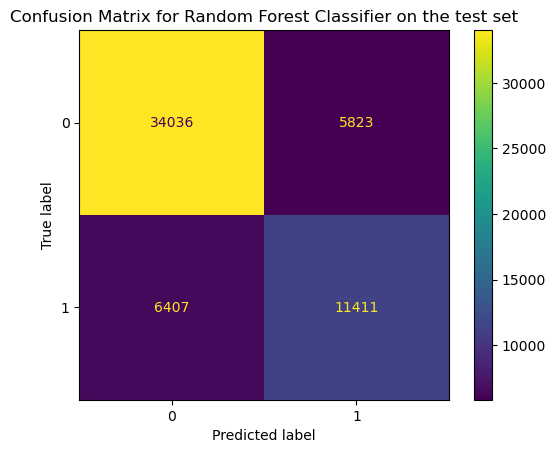

In [41]:
# Predict on the validation set
y_val_pred = best_rf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Predict on the test set
y_test_pred = best_rf.predict(X_test)
# Calculate the accuracy of the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}\n")

# Print out the classification report which provides a summary of the model's performance
print("**Classification report for Random Forest Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred))

# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on the test set')


### XGBoost

In [42]:
param_grid = {
    'n_estimators': [100, 200],  # Number of gradient boosted trees.
    'learning_rate': [0.05, 0.1],  # Step size shrinkage used to prevent overfitting.
    'max_depth': [3, 5],  # Maximum tree depth for base learners.
    'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child.
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition.
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances.
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree.
}


# Create the XGBoost classifier instance
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# After grid search completes
print(f"Best parameters found: {grid_search.best_params_}")
best_xgb_clf = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}


In [43]:
# Predict on the validation set
y_val_pred_xgb = best_xgb_clf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Validation Accuracy XGBoost: {val_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the test set:**\n")
print(classification_report(y_val, y_val_pred_xgb))

# Make predictions on the test set using the best model
y_test_pred_xgb = best_xgb_clf.predict(X_test)
# Calculate the accuracy of the model on the test set
test_acc_xgb = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy XGBoost: {test_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred_xgb))

Validation Accuracy XGBoost: 0.7710627135609015

**Classification report for XGBoost Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83     37618
         1.0       0.69      0.63      0.66     20328

    accuracy                           0.77     57946
   macro avg       0.75      0.74      0.74     57946
weighted avg       0.77      0.77      0.77     57946

Testing Accuracy XGBoost: 0.7879570712762453

**Classification report for XGBoost Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     39859
         1.0       0.61      0.64      0.62     17818

    accuracy                           0.76     57677
   macro avg       0.72      0.73      0.72     57677
weighted avg       0.76      0.76      0.76     57677



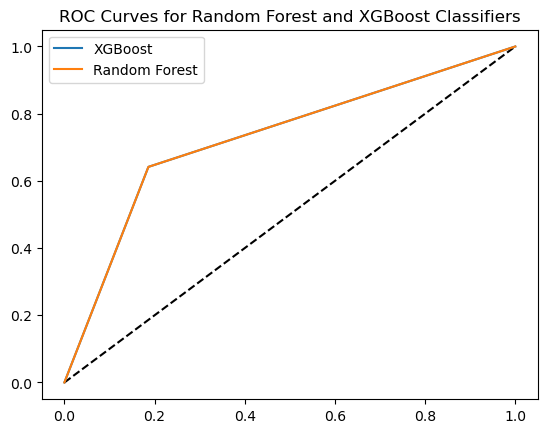

In [44]:
# Plot the ROC curve for XGBoost and Random Forest
fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.title('ROC Curves for Random Forest and XGBoost Classifiers')
plt.legend()
plt.show()

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_log_reg = log_reg.predict(X_val)

# Calculate and print the accuracy of the model on the validation set
accuracy_val_log_reg = accuracy_score(y_val, y_val_pred_log_reg)
print("Accuracy of Logistic Regression on the validation set:", accuracy_val_log_reg)

# Make predictions on the test set
y_test_pred_log_reg = log_reg.predict(X_test)

# Calculate and print the accuracy of the model on the test set
accuracy_test_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
print("\nAccuracy of Logistic Regression on the test set:", accuracy_test_log_reg)

# Print the model's coefficients
coefs_log_reg = log_reg.coef_[0]
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {coefs_log_reg[i]}")



Accuracy of Logistic Regression on the validation set: 0.7355814033755566

Accuracy of Logistic Regression on the test set: 0.6976437748149176
TEMP_Z1: 0.8806440082108243
PYRO_2_FRST_3_ZONE: -0.6610923521087577
SPEED_PROCESS: 0.34227392455154976
FILL_TIRO: 0.7323660631275436
LASER_FRN_1: 0.1119597202706077
ELET_FE2: -0.05755102228034631
DEC_H2SO4: 0.2158941825914369
ELET_H2SO4: -0.11317329380003767
EXT_1: 0.08934589411432885
LASER_FRN_2: -0.43216493512091275
FILL_ALL: -0.5942018491843924
LASER_FRN_9: 0.1558359718334832
DEC_FE2: 0.04819598454619408
DEC_FE3: 0.10267059457252463
LASER_FRN_8: -0.14925389840999898
SPZ1_R1_ASS: -0.05633243517268972
FRN_FURNACE_PRESSURE: -0.17208117448661114
AIR_CH4_1: 0.04007945896181402
FILL_FORZA: 0.08246599189345737
PRES_ZONA3_MEASURED: 0.2006982121115131


In [46]:
# Print out the classification report which provides a summary of the model's performance
# on each class (classification report shows precision, recall, and F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_log_reg))

# Create a confusion matrix to visualize the performance of the model
cm_log_reg = metrics.confusion_matrix(y_test, y_test_pred_log_reg)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.76      0.78     39859
         1.0       0.51      0.55      0.53     17818

    accuracy                           0.70     57677
   macro avg       0.65      0.66      0.65     57677
weighted avg       0.70      0.70      0.70     57677



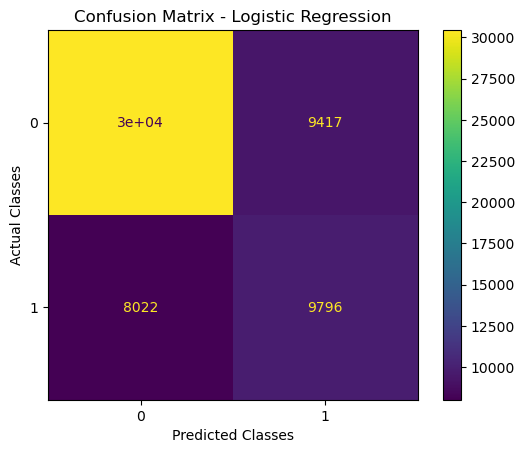

In [47]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
disp.plot()
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

### Using several classifiers and tuning parameters - Parameters grid (Seba)

In [48]:
# model_lbls = ['dt' # decision tree
#              ,'nb' # gaussian naive bayes
#              ,'lp'   # linear perceptron
#       #        ,'svc'  # support vector # deactivate if running time becomes too long
#              ,'knn'  # k nearest neighbours
#              ,'adb'  # adaboost
#              ,'rf'   # random forest
#             ]

# # For each model we have to prepare the ranges of the hyperparameters that will be used
# # and also a name of the model that will be put in output 
# models = {
#     'dt': {'name': 'Decision Tree       ',
#            'estimator': DecisionTreeClassifier(random_state=random_state), # We difine inside the estimator
#            # the hyperparapeter that will not be subject to the parameter grid (GridSearchCV)
#            'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],  
#                    # For max_depth we create                 #here we say if we want the dataset 
#                    # a list of numbers bw 1 and 19           # as it is or balanced                                                             
#           },
#     'nb': {'name': 'Gaussian Naive Bayes',
#            'estimator': GaussianNB(),
#            'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
#            # the NB has only one parameter
#           },
#     'lp': {'name': 'Linear Perceptron   ',
#            'estimator': Perceptron(random_state=random_state),
#            'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
#           },
#     'svc':{'name': 'Support Vector      ',
#            'estimator': SVC(random_state=random_state), 
#            'param': [{'kernel': ['rbf'], # we have hyperparameters for each kernel
#                     'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100],
#                     },
#                     {'kernel': ['linear'],
#                      'C': [1, 10, 100],                     
#              },
#                    ]
#           },
#     'knn':{'name': 'K Nearest Neighbor ',
#            'estimator': KNeighborsClassifier(),
#            'param': [{'n_neighbors': list(range(1,7))}]
#        },
#     'adb':{'name': 'AdaBoost           ',
#            'estimator': AdaBoostClassifier(random_state=random_state),
#            'param': [{'n_estimators':[10,20,30,40,50]
#                      ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
#           },
#     'rf': {'name': 'Random forest       ',
#            'estimator': RandomForestClassifier(random_state=random_state),
#            'param': [{'max_depth': [*range(4,10)]
#                      ,'n_estimators':[*range(10,60,10)]}]
#           }

# }

In [49]:
# # model accuracy

# for model_lbl in model_lbls:
#     print(f"Processing model: {models[model_lbl]['name']}")
#     model = models[model_lbl]['estimator']
#     param = models[model_lbl]['param']
#     grid = GridSearchCV(estimator=model, param_grid=param, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))
#     grid.fit(Xtrain, ytrain)
#     print(f"Best parameters: {grid.best_params_}")
#     ytrain_pred = grid.predict(Xtrain)
#     ytest_pred = grid.predict(Xtest)
#     train_accuracy = accuracy_score(ytrain, ytrain_pred)
#     test_accuracy = accuracy_score(ytest, ytest_pred)
#     print(f"Train accuracy: {train_accuracy}")
#     print(f"Test accuracy: {test_accuracy}")
#     results[model_lbl] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
#     results_df = results_df.append({'model': models[model_lbl]['name'], 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}, ignore_index=True)

# results_df

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['model'], results_df['train_accuracy'], label='Train Accuracy', marker='o')
# plt.plot(results_df['model'], results_df['test_accuracy'], label='Test Accuracy', marker='o')
# plt.xlabel('Model')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy')
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()